In [110]:
import pandas as pd
import numpy as np
# import the libraries
import datetime


import seaborn as sns # import seaborn for visualization of data
%matplotlib inline
import matplotlib.pyplot as plt#
import matplotlib as mpl
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error


#import packages related to the autocorrelation packages and Augmented Dickey Fuller test
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import ar_select_order, AutoReg
import statsmodels
from statsmodels.tsa import stattools



# import libraries to spli data in timeseries and ARIM model
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)


In [5]:
# Import the data from a txt file with lines of header and a specified datetime column

df = pd.read_csv("raw.txt", skiprows =18 ,delimiter=",",parse_dates=True,index_col='    DATE')

df.head()

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0


In [6]:
df.columns

Index([' SOUID', '   TG', ' Q_TG'], dtype='object')

In [7]:
# Rename columns to make it easy to handle
df.rename(columns = {' SOUID':'souid','    DATE':'date', '   TG':'temp', ' Q_TG':'Q_TG'}, inplace = True)

# Clean Data

In [8]:

df['real_temp'] = 0.1 * df['temp']
df.head()

,souid,temp,Q_TG,real_temp
DATE,,,,
1876-01-01,127488,22,0,2.2
1876-01-02,127488,25,0,2.5
1876-01-03,127488,3,0,0.3
1876-01-04,127488,-58,0,-5.8
1876-01-05,127488,-98,0,-9.8


In [9]:
df.info()
data = df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53416 entries, 1876-01-01 to 2022-03-31
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   souid      53416 non-null  int64  
 1   temp       53416 non-null  int64  
 2   Q_TG       53416 non-null  int64  
 3   real_temp  53416 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 2.0 MB


In [10]:
# Create columns from datetime
data['day'] = data.index.day
data['month'] = data.index.month
data['year'] = data.index.year

In [11]:
df['timestep'] = list(range(len(df)))

In [12]:
data.head()

,souid,temp,Q_TG,real_temp,day,month,year,timestep
DATE,,,,,,,,
1876-01-01,127488,22,0,2.2,1,1,1876,0
1876-01-02,127488,25,0,2.5,2,1,1876,1
1876-01-03,127488,3,0,0.3,3,1,1876,2
1876-01-04,127488,-58,0,-5.8,4,1,1876,3
1876-01-05,127488,-98,0,-9.8,5,1,1876,4


In [13]:
pd.isnull(data).sum()

souid        0
temp         0
Q_TG         0
real_temp    0
day          0
month        0
year         0
timestep     0
dtype: int64

In [14]:
data[data['real_temp']<-50]

,souid,temp,Q_TG,real_temp,day,month,year,timestep
DATE,,,,,,,,
1945-04-25,127488,-9999,9,-999.9,25,4,1945,25316
1945-04-26,127488,-9999,9,-999.9,26,4,1945,25317
1945-04-27,127488,-9999,9,-999.9,27,4,1945,25318
1945-04-28,127488,-9999,9,-999.9,28,4,1945,25319
1945-04-29,127488,-9999,9,-999.9,29,4,1945,25320
...,...,...,...,...,...,...,...,...
1945-11-02,127488,-9999,9,-999.9,2,11,1945,25507
1945-11-03,127488,-9999,9,-999.9,3,11,1945,25508
1945-11-04,127488,-9999,9,-999.9,4,11,1945,25509


In [15]:
# data need to be fitted !!!! data.loc['1945-04-25 00:00:00':'1945-11-05 00:00:00','timestep']
# Idea to take the year before and after and find an average of temperatures and use these for the 1945 year!
# start44 = data.loc['1944-04-25 00:00:00':'1944-11-05 00:00:00','timestep'][0]
# end44 = data.loc['1944-04-25 00:00:00':'1944-11-05 00:00:00','timestep'][-1]
# start46 = data.loc['1946-04-25 00:00:00':'1946-11-05 00:00:00','timestep'][0]
# end46 = data.loc['1946-04-25 00:00:00':'1946-11-05 00:00:00','timestep'][-1]
#data.loc['1945-04-25 00:00:00':'1945-11-05 00:00:00','real_temp'] = data.loc['1944-04-25 00:00:00':'1944-11-05 00:00:00','real_temp']

In [16]:
# Fix the missing values in temperature.
# Start with creating a new column that contains the values of Real_temp withe row_shifting of one year in time
#data['shifted'] = data['real_temp'].shift(-365)
#As a result we have in the shifted column the values of the previous year and we substitute this part of the year with the shifted values
# In other words its a data pach with data from 1944 year
#data.loc[data['real_temp']< -50, 'real_temp'] = data.loc[data['Q_TG']== 9, 'shifted']
# Drop data columns not needed
#data.drop(columns=['souid', 'temp','shifted'],inplace = True)

In [17]:
# Fix the missing values in temperature.
# Start with creating a new column that contains the values of Real_temp withe row_shifting of one year in time
data['shiftedup'] = data['real_temp'].shift(-365)
data['shifteddown'] = data['real_temp'].shift(365)
#As a result we have in the shifted column the values of the previous year and we substitute this part of the year with the shifted values
# In other words its a data pach with data from 1944 year
data.loc[data['real_temp']< -50, 'real_temp'] = (data.loc[data['Q_TG']== 9, 'shiftedup'] + data.loc[data['Q_TG']== 9, 'shifteddown'])/2
# Drop data columns not needed
data.drop(columns=['souid', 'temp','shiftedup','shifteddown'],inplace = True)

In [18]:
pd.isnull(data).sum()

Q_TG         0
real_temp    1
day          0
month        0
year         0
timestep     0
dtype: int64

In [19]:
# Check which value is still missing and replace it manually with the value of the previous year
df[df['real_temp'].isna()]
data.loc['2022-03-31 00:00:00','real_temp'] = 7.7

In [20]:
pd.isnull(data).sum()

Q_TG         0
real_temp    0
day          0
month        0
year         0
timestep     0
dtype: int64

In [104]:
# make a copy of the data frame after we cleaned data. This step is useful for the ARIMA model later.
clean_data = df.copy()

In [21]:
# Replace outliers with NaN values if needed
#df['temp'].replace(-9999, pd.NA , inplace=True)

In [22]:
# Attempt to fill in the outliers with data from the previous year with other way. 
# Not succesfull
#data.loc['1945-04-25 00:00:00':'1945-11-05 00:00:00','real_temp'] = data.loc['1944-04-25 00:00:00':'1944-11-05 00:00:00','real_temp']
#data.loc['2022-03-31 00:00:00':'2022-03-30 00:00:00']['real_temp'] = data.loc['2021-03-31 00:00:00':'2021-03-30 00:00:00']['real_temp']

# Have a look of the data

<AxesSubplot:xlabel='year', ylabel='real_temp'>

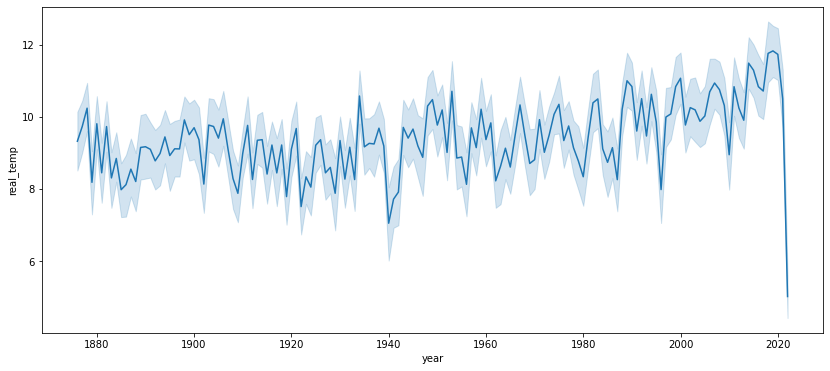

In [23]:
sns.lineplot(x = data['year'], y =data['real_temp'])
#plt.xlim(1000, 3000)

# use group by

In [24]:
data_month = data.groupby(['month','day']).mean()
data_month.head(2)


Q_TG  real_temp    year      timestep
month day                                       
1     1     0.0   0.200000  1949.0  26662.795918
      2     0.0   0.431973  1949.0  26663.795918

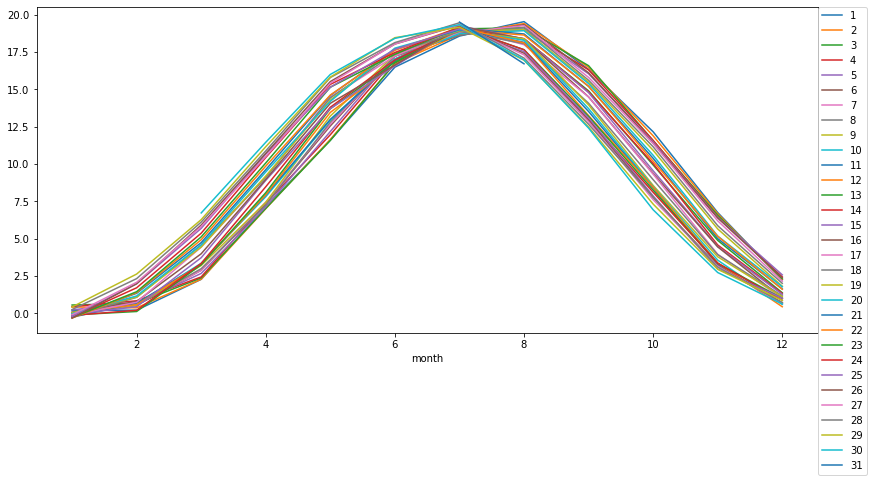

In [25]:
Months =data_month["real_temp"].unstack(level=1).plot.line()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)

<AxesSubplot:>

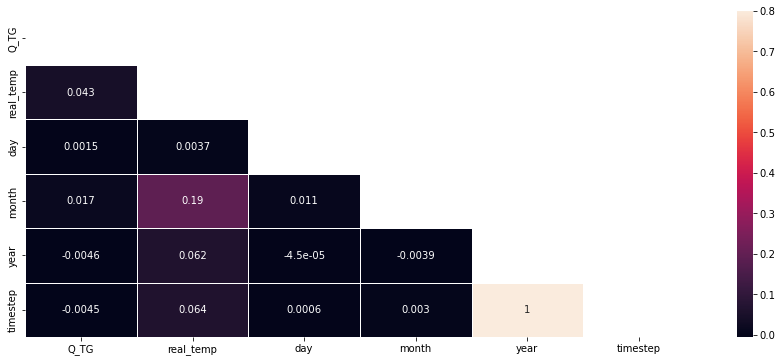

In [26]:
corrMatt = data.corr()
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=False, annot=True, ax=ax, linewidths=1)

# First fit the trend! 

- try a linear

In [27]:
# Run a Linear Regression
m = LinearRegression()
data = data[(data['year'] <2021)]
X = data[['timestep']]
y = data['real_temp']
m.fit(X, y)

LinearRegression()

In [28]:
# Use the model to make a prediction
data['trend'] = m.predict(X)
data.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Q_TG,real_temp,day,month,year,timestep,trend
DATE,,,,,,,
1876-01-01,0,2.2,1,1,1876,0,8.526995
1876-01-02,0,2.5,2,1,1876,1,8.527028
1876-01-03,0,0.3,3,1,1876,2,8.527061
1876-01-04,0,-5.8,4,1,1876,3,8.527095
1876-01-05,0,-9.8,5,1,1876,4,8.527128


<AxesSubplot:xlabel='year', ylabel='trend'>

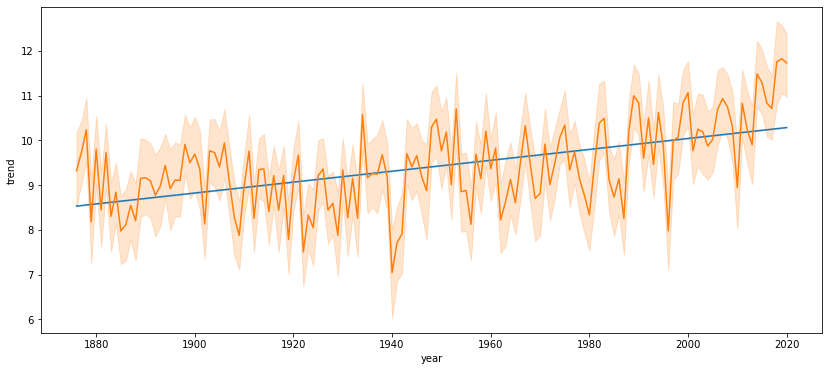

In [29]:
# plot data 
sns.lineplot(x = data['year'], y =data['trend'])
sns.lineplot(x = data['year'], y =data['real_temp'])


- try a polynomial low degree

In [30]:
# Fit the data with a polynomial to see the time evolution
def fit_with_poly(X, y, deg):
    poly = PolynomialFeatures(degree=deg,include_bias= True, interaction_only=False)
    X_poly = poly.fit_transform(X)
    lr = LinearRegression()
    lr.fit(X_poly,y)
    y_pred_poly = lr.predict(X_poly)
    return y_pred_poly, X_poly

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:xlabel='year', ylabel='trend'>

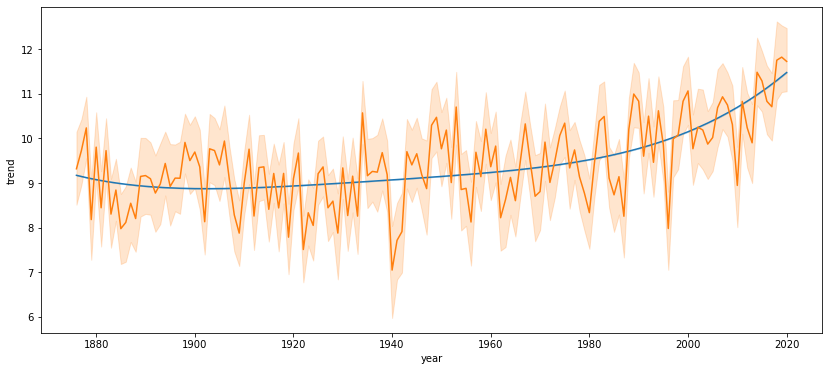

In [31]:
y_pred_poly, X_poly = fit_with_poly(X,y,4)
# Use the model to make a prediction
data['trend'] = y_pred_poly

sns.lineplot(x = data['year'], y =data['trend'])
sns.lineplot(x = data['year'], y =data['real_temp'])

# Step 5 - Model the seasonality

In [32]:
pd.get_dummies(data.index.month, prefix='month').set_index(data.index)

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,
1876-01-01,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-02,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-03,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-04,1,0,0,0,0,0,0,0,0,0,0,0
1876-01-05,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0,0,0,0,0,0,0,0,0,0,0,1
2020-12-28,0,0,0,0,0,0,0,0,0,0,0,1
2020-12-29,0,0,0,0,0,0,0,0,0,0,0,1


In [33]:
# One-Hot-Encoding the month
seasonal_dummies = pd.get_dummies(data.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(data.index)
# sklearn.preprocessing.OneHotEncoder

data = data.join(seasonal_dummies)

In [34]:
# Define X and y
X = data.drop(columns=['Q_TG','real_temp','day', 'year', 'month', 'trend'])
y = data['real_temp']

In [35]:
y

    DATE
1876-01-01    2.2
1876-01-02    2.5
1876-01-03    0.3
1876-01-04   -5.8
1876-01-05   -9.8
             ... 
2020-12-27    1.6
2020-12-28    2.8
2020-12-29    2.3
2020-12-30    2.5
2020-12-31    2.6
Name: real_temp, Length: 52961, dtype: float64

In [36]:
lr =LinearRegression()
lr.fit(X, y)

LinearRegression()

In [37]:
# Create a model with trend and seasonality
data['trend_seasonal'] = lr.predict(X)
data.head()

,Q_TG,real_temp,day,month,year,timestep,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
DATE,,,,,,,,,,,,,,,,,,,
1876-01-01,0,2.2,1,1,1876,0,9.187025,0,0,0,0,0,0,0,0,0,0,0,-0.875645
1876-01-02,0,2.5,2,1,1876,1,9.186948,0,0,0,0,0,0,0,0,0,0,0,-0.875612
1876-01-03,0,0.3,3,1,1876,2,9.186871,0,0,0,0,0,0,0,0,0,0,0,-0.875580
1876-01-04,0,-5.8,4,1,1876,3,9.186794,0,0,0,0,0,0,0,0,0,0,0,-0.875547
1876-01-05,0,-9.8,5,1,1876,4,9.186717,0,0,0,0,0,0,0,0,0,0,0,-0.875514


(1000.0, 3000.0)

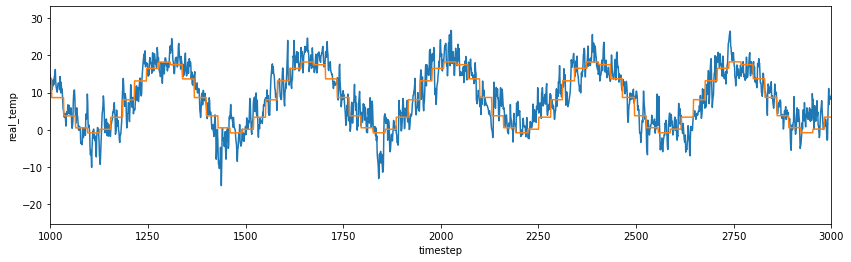

In [ ]:
fig, axes = plt.subplots(1)
fig.set_size_inches(14, 4)
sns.lineplot(data=data, x='timestep', y='real_temp')
sns.lineplot(data=data, x='timestep', y='trend_seasonal')
plt.xlim(1000, 3000)

# Step 7 - Extract the remainder

In [38]:
# We want to extract the part of the model that the trend_seasonal is not able to explain
data['remainder'] = data['real_temp'] - data['trend_seasonal']

<AxesSubplot:xlabel='year', ylabel='remainder'>

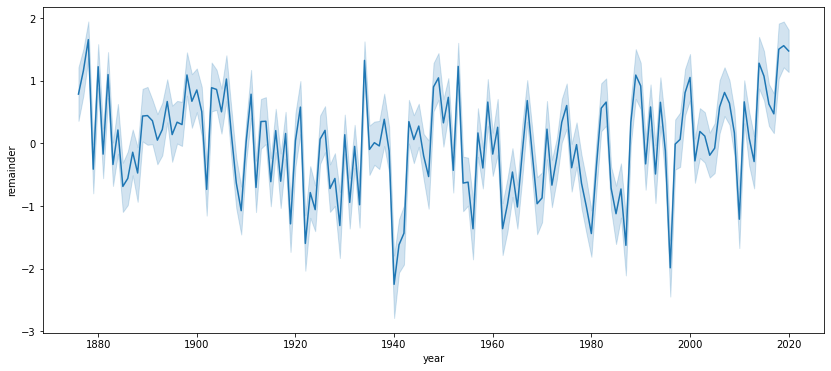

In [39]:
sns.lineplot(x = data['year'], y =data['remainder'])

# Step 8 - Save the remainder

In [ ]:
data['remainder'].to_csv('data_remainder_alex.csv')

-from the visualization of the result I understand that we have a stationary time series.

#Now test the mean value and standard deviation
#See if the series is a white noise
- Conditions
- - the average value is zero  [ ]
- - constant standart deviation [ ]
- - no significant correlation between series and lagged version [ ]

In [55]:
dt = data['remainder']
dt

    DATE
1876-01-01    3.075645
1876-01-02    3.375612
1876-01-03    1.175580
1876-01-04   -4.924453
1876-01-05   -8.924486
                ...   
2020-12-27   -0.615936
2020-12-28    0.584031
2020-12-29    0.083998
2020-12-30    0.283966
2020-12-31    0.383933
Name: remainder, Length: 52961, dtype: float64

In [56]:
# find which numbers divide the number of rows without remainder
for i in range(1, 52961):    
    if 52961 % i == 0:
        print("The number", i, "is ok.")

The number 1 is ok.
The number 211 is ok.
The number 251 is ok.


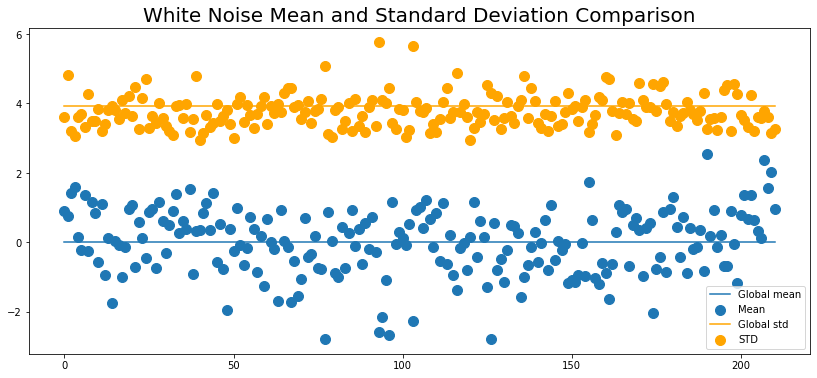

In [57]:
## Compare mean and standard deviation with time
# make a list
dt = data['remainder']
# Split into an arbitraty number of chunks

white_noise_chunks = np.split(dt, 211)
means, stds = [], []

# # Get the mean and std values for every chunk
for chunk in white_noise_chunks:
    means.append(np.mean(chunk))
    stds.append(np.std(chunk))
    
    
# # # Plot
plt.title('White Noise Mean and Standard Deviation Comparison', size=20)
plt.plot(np.arange(len(means)), [dt.mean()] * len(means), label='Global mean', lw=1.5)
plt.scatter(x=np.arange(len(means)), y=means, label='Mean', s=100)
plt.plot(np.arange(len(stds)), [dt.std()] * len(stds), label='Global std', lw=1.5, color='orange')
plt.scatter(x=np.arange(len(stds)), y=stds, label='STD', color='orange', s=100)
plt.legend();

- From the result we see that mean value and standard deviation show to be time independent. That is extra indication that our remainder is stationary so we can continue with forcasting!

# Use autoregressive model to find the number of lags from comparing autocorrelations and pacf/acf

In [66]:
dt = pd.read_csv('data_remainder_alex.csv', index_col = 0, parse_dates = True)
dt.head()

,remainder
DATE,
1876-01-01,3.075639
1876-01-02,3.375606
1876-01-03,1.175574
1876-01-04,-4.924459
1876-01-05,-8.924492


In [67]:
# Create the different lagging columns with shift 1 
dt['lag1'] = dt['remainder'].shift(1)
dt['lag2'] = dt['remainder'].shift(2)
dt['lag3'] = dt['remainder'].shift(3)
dt

,remainder,lag1,lag2,lag3
DATE,,,,
1876-01-01,3.075639,NaN,NaN,NaN
1876-01-02,3.375606,3.075639,NaN,NaN
1876-01-03,1.175574,3.375606,3.075639,NaN
1876-01-04,-4.924459,1.175574,3.375606,3.075639
1876-01-05,-8.924492,-4.924459,1.175574,3.375606
...,...,...,...,...
2020-12-27,-0.615930,-1.215898,0.484135,4.684168
2020-12-28,0.584037,-0.615930,-1.215898,0.484135
2020-12-29,0.084004,0.584037,-0.615930,-1.215898


In [68]:
dt.corr()  # see the correlation between the columns. 1 means perfect correlation

,remainder,lag1,lag2,lag3
remainder,1.000000,0.803688,0.599116,0.463398
lag1,0.803688,1.000000,0.803688,0.599116
lag2,0.599116,0.803688,1.000000,0.803688
lag3,0.463398,0.599116,0.803688,1.000000


<AxesSubplot:>

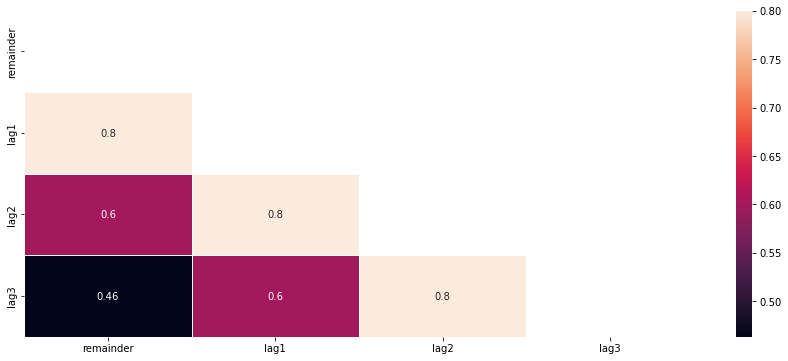

In [69]:
# see the correlations with a heat map
corrMatt = dt.corr()
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=False, annot=True, ax=ax, linewidths=1)

(0.0, 0.6)

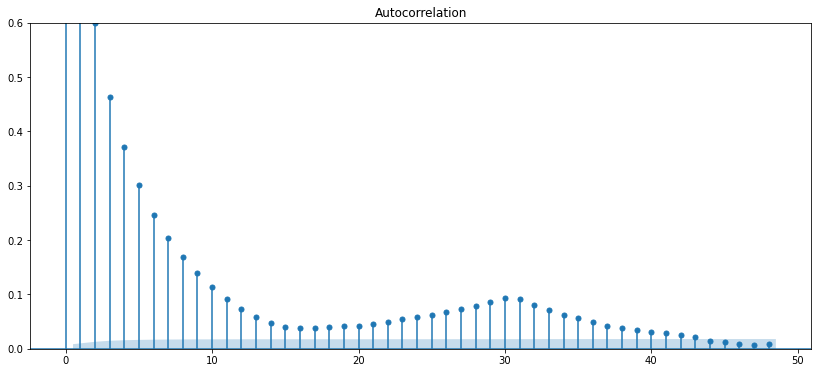

In [75]:
# plot the acf and the pacf
plot_acf(dt['remainder']); # X axis are the lags

plt.ylim(0,0.6)

- we find that the autocorrelation function decreases gradually.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


(-0.02, 0.02)

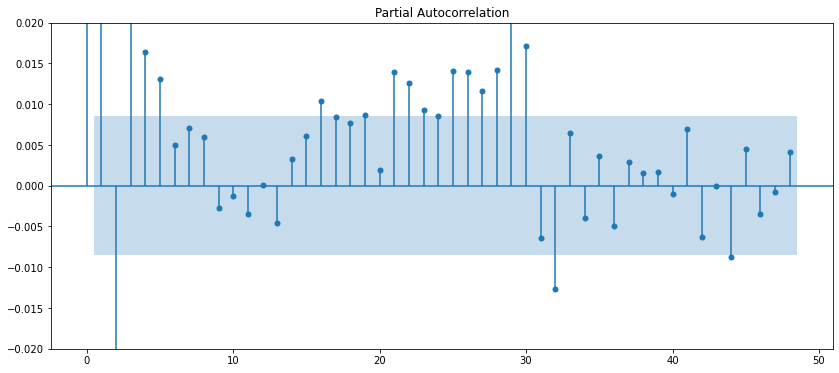

In [78]:
plot_pacf(dt['remainder']);
plt.ylim(-0.02,0.02)

- while the partial autocorrelation function abruptly decreases with at least the first 5 shifts well outside the 5% box window.
 

In [88]:
ar_order = ar_select_order(dt['remainder'], maxlag = 15);
print(f'The number of lags that should be included in the linear regression model are {ar_order.ar_lags[-1]}.')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


The number of lags that should be included in the linear regression model are 4.


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


# Use AutoRegression to see if the remainder is stationary and compare the result with the result above

- In a similar way we will test the findings for the stationarity of the signal by calculationg the Augmented Dickey Fuller, comparing the p values.

In [95]:
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""adf_stats: {adf_stats}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            CI 99%: {levels['1%']}
            CI 95%: {levels['5%']}
            CI 90%: {levels['10%']}
            information criterion (AIC): {information_criterion}
            """)
   

In [96]:
print_adf(dt['remainder'])

adf_stats: -23.65229121320896
            p: 0.0 
            used lag: 58 
            number of observations: 52902
            CI 99%: -3.430473617582172
            CI 95%: -2.861594636498603
            CI 90%: -2.566799081189713
            information criterion (AIC): 238635.51068212208
            


- using the non-hypothesis that the signal is not stationary we conclude that the signal is indeed stationary.
- we hypothesize that the point of adf is well inside the normal distribution. In the result the adf = - 24 << IC 99% which says that
the hypothesis of non-stationarity is incorrect so we have a stationary time series.
- p value is a really small value, p<<0.05 (hard threshold) which confirms the stationaroty.

In [98]:
ar_model = AutoReg(endog=dt['remainder'], lags=1).fit()
ar_model.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                52961
Model:                     AutoReg(1)   Log Likelihood             -120109.261
Method:               Conditional MLE   S.D. of innovations              2.337
Date:                Fri, 29 Apr 2022   AIC                         240224.521
Time:                        06:11:14   BIC                         240251.153
Sample:                    01-02-1876   HQIC                        240232.841
                         - 12-31-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.225e-05      0.010     -0.005      0.996      -0.020       0.020
remainder.L1     0.8037      0.003    310.819      0.000       0.799       0.809
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2443           +0.0000j            1.2443            0.0000
-----------------------------------------------------------------------------
"""

In [100]:
ar_model = AutoReg(endog=dt['remainder'], lags=4).fit()
ar_model.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                52961
Model:                     AutoReg(4)   Log Likelihood             -119495.762
Method:               Conditional MLE   S.D. of innovations              2.311
Date:                Fri, 29 Apr 2022   AIC                         239003.525
Time:                        06:11:51   BIC                         239056.788
Sample:                    01-05-1876   HQIC                        239020.165
                         - 12-31-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         6.631e-05      0.010      0.007      0.995      -0.020       0.020
remainder.L1     0.9180      0.004    211.297      0.000       0.910       0.927
remainder.L2    -0.1929      0.006    -32.735      0.000      -0.204      -0.181
remainder.L3     0.0553      0.006      9.387      0.000       0.044       0.067
remainder.L4     0.0164      0.004      3.765      0.000       0.008       0.025
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2572           -0.0000j            1.2572           -0.0000
AR.2            1.0004           -2.5146j            2.7063           -0.1897
AR.3            1.0004           +2.5146j            2.7063            0.1897
AR.4           -6.6402           -0.0000j            6.6402           -0.5000
-----------------------------------------------------------------------------
"""

- Comparing AIC the use of 4 lags gives a slightly better fit compared to 1 lag. The p values are small for the remainders coefficients with the z values (equivalent to
the adf) well outside the normal distribution (0.025).

# Use Arima for prediction
- after cleaning data split in train test data 30/70%
- fit the raw data with the Auto Arima model using only the train data set
- - use ... accuracy(name of model) to find teh MAE scoring of the fit
- predict the range of years that are in the test period
- - sklearn.meatrics import mean_absolute_error(y_test, y_pred) gives the errorbar in the same units
- after teh model is correct then forecast future values, using the model for future period.

- split the data in a 30/70 percentage.

In [ ]:
# manipulate the frame for ARIMA model
clean_data.drop(columns=['Q_TG','day','month','year','timestep'],inplace=True)

In [108]:
clean_data.head()

,real_temp
DATE,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [113]:
# split train and test data
clean_data.inde

DatetimeIndex(['1876-01-01', '1876-01-02', '1876-01-03', '1876-01-04',
               '1876-01-05', '1876-01-06', '1876-01-07', '1876-01-08',
               '1876-01-09', '1876-01-10',
               ...
               '2022-03-22', '2022-03-23', '2022-03-24', '2022-03-25',
               '2022-03-26', '2022-03-27', '2022-03-28', '2022-03-29',
               '2022-03-30', '2022-03-31'],
              dtype='datetime64[ns]', name='    DATE', length=53416, freq=None)

In [117]:
train = clean_data.loc['1876-01-01':'1970-12-29']
test = clean_data.loc['1970-12-30':'2022-03-31']

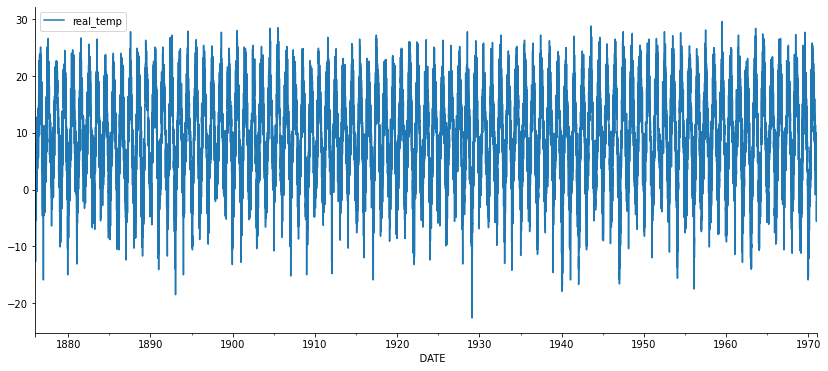

In [119]:
train.plot()
sns.despine()